# Table of Contents

*   [Target Audience](#target-audience)
*   [Overview](#overview)
*   [Contributions](#contributions)
*   [Software Requirements](software-requirements)
*   [Data Source](data-source)
*   [Temporal Forecasting](temporal-forecasting)
*   [Spatial Downscaling](spatial-downscaling)

<a name="target-audience"></a>
# Target Audience


*   Climate scientists seeking to explore ML tools, technologies, and resources to tackle a domain-specific problem in climate change. 
*   Data scientists with prior background in deep learning looking for concrete examples on how to model climate extremes using AI.

<a name="overview"></a>
# Overview

Climate change has led to a rapid increase in the occurrence of extreme weather events globally, including floods, droughts, and wildfires. In the longer term, some regions will experience aridification while others will risk sinking due to rising sea levels. Typically, such predictions are done via weather and climate models that simulate the physical interactions between the atmospheric, oceanic, and land surface processes that operate at different scales. Due to the inherent complexity, these climate models can be inaccurate or computationally expensive to run, especially for detecting climate extremes at high spatiotemporal resolutions. In this tutorial, we aim to introduce the participants to machine learning approaches for addressing two fundamental challenges:

(1) **Temporal Forecasting**: The goal is to predict climate variables into the future. \
(2) **Spatial Downscaling**: The goal is to learn a mapping that transforms low-resolution outputs of climate models into high-resolution regional forecasts. 

We illustrate the two key challenges in predicting temperature, a key indicator of global warming levels around the world, in the figure below. Given a temperature grid at a particular resolution **R** at a time stamp **T**, temporal forecasting focuses on predicting the temperature at a future time stamp **T+H** where **H** is the prediction horizon whereas the climate downscaling focuses on predicting the temperature at the same timestep T but at a higher resolution **(R' > R)**. 

<a name="contributions"></a>
# Contributions

Through introductory presentations and colab notebooks, we aim to expose the participants to: 

(a) **APIs** for accessing and navigating popular repositories that host global climate data, such as the Copernicus data store. \
(b) Identifying **relevant datasets** and providing functionality to preprocess them. \
(c) **Algorithms** for training machine learning models. \
(d) **Metrics** for evaluating model performance. \
(e) **Visualization** tools for both the dataset and predicted outputs. 

<a name="software-requirements"></a>
# Software Requirements
This notebook requires the following libraries:
*   climate_tutorial (pip)

`climate_tutorial` contains the source files used modeling climate extremes.

The package is written using `PyTorch` machine learning library.

In [3]:
%%capture
!pip install git+https://github.com/tung-nd/climate_tutorial.git
!pip install importlib-metadata==4.13.0

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from climate_tutorial.data import download
download(root = "/content/drive/MyDrive/Climate/.climate_tutorial", source = "weatherbench", variable = "geopotential_500", dataset = "era5", resolution = "5.625")
download(root = "/content/drive/MyDrive/Climate/.climate_tutorial", source = "weatherbench", variable = "temperature_850", dataset = "era5", resolution = "5.625")

<a name="data-source"></a>
# Data Source

[1] provides a comprehensive list of typical datasets and benchmarks for weather prediction. 

Among the list of popular datasets, we focus this tutorial on the **ERA5** dataset that provides an hourly estimate of a large number of atmospheric, land and oceanic climate variables. 

<br>
<center><img src="https://cds.climate.copernicus.eu/sites/default/files/cdsapp/copernicus-logo.png" width=300></center>
<br>

ERA5 consists of the climate variable data from 1959 to present. The ERA5 dataset is freely-accessible to the community on the Climate Data Store [(CDS)](https://cds.climate.copernicus.eu/#!/search?text=ERA5&type=dataset) hosted by the European Union's Earth observation programme, [Copernicus](https://www.copernicus.eu/en/about-copernicus).  The users can visit [https://cds.climate.copernicus.eu/api-how-to](https://cds.climate.copernicus.eu/api-how-to#install-the-cds-api-key) to install the CDS API key required to access their data. 




The authors from [2] (WeatherBench dataset) downloaded the ERA5 data from CDS API for a subset of climate variable and preprocessed it at multiple resolutions. The data is freely accessible to anyone at [https://dataserv.ub.tum.de/index.php/s/m1524895?path=%2F](https://dataserv.ub.tum.de/index.php/s/m1524895?path=%2F).

<br>
<center><img src="https://github.com/ai4environment/WeatherBench/raw/master/figures/logo_text_left.png?raw=true" width=500></center>
<br>

_Our package provides the users with a way to download data from ERA5 as well as WeatherBench depending upon their application._



<br/><br/>

**References:**

[1] Ren X, Li X, Ren K, Song J, Xu Z, Deng K, Wang X. Deep learning-based weather prediction: a survey. Big Data Research. 2021 Feb 15;23:100178 [(Paper)](https://www.sciencedirect.com/science/article/pii/S2214579620300460). \
[2] Rasp S, Dueben PD, Scher S, Weyn JA, Mouatadid S, Thuerey N. WeatherBench: a benchmark data set for data‐driven weather forecasting. Journal of Advances in Modeling Earth Systems. 2020 Nov;12(11):e2020MS002203 [(Paper)](https://arxiv.org/abs/2002.00469).

# Temporal Forecasting - Z500

## Data Preprocessing


The data is stored in the [NetCDF](https://en.wikipedia.org/wiki/NetCDF) files with _.nc_ extension. One of the distinct features of this format is the **named** specification to the coordinates and the data variables. 

As shown below, we first merge all the yearly NetCDF files, and display the structure of the format. xarray library is used to read the NetCDF files. It allows the users to manipulate data based on more informative labels instead of integer location. 



In [ ]:
from climate_tutorial.utils.data import load_dataset, view

dataset = load_dataset("/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/geopotential_500")
view(dataset)

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

## Data Conversion
We further convert the *NetCDF* files to *PyTorch* Dataloaders.

**Pros**: We can use the dataloaders for training and evaluating neural networks.\
**Cons**: We loose useful meta information (such as 'time', 'location') during conversion as dataloaders only allow for integer location based treatment. 

We store the useful information about the data ('lat', 'long') of the regions as _data members_ of our dataloaders. 



In [ ]:
from climate_tutorial.utils.datetime import Year, Days, Hours
from climate_tutorial.data import DataModule

data_module = DataModule(
    dataset = "ERA5",
    task = "forecasting",
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/",
    in_vars = ["geopotential_500"],
    out_vars = ["geopotential_500"],
    train_start_year = Year(1979),
    val_start_year = Year(2015),
    test_start_year = Year(2017),
    end_year = Year(2018),
    pred_range = Days(3),
    subsample = Hours(6),
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


  0%|          | 0/36 [00:00<?, ?it/s]

Creating val dataset


  0%|          | 0/2 [00:00<?, ?it/s]

Creating test dataset


  0%|          | 0/2 [00:00<?, ?it/s]

## Model initialization 

In [ ]:
from climate_tutorial.models import load_model

# model_kwargs = {
#     "img_size": [32, 64],
#     "patch_size": 2,
#     "drop_path": 0.1,
#     "drop_rate": 0.1,
#     "learn_pos_emb": True,
#     "in_vars": data_module.hparams.in_vars,
#     "out_vars": data_module.hparams.out_vars,
#     "embed_dim": 128,
#     "depth": 8,
#     "decoder_depth": 0,
#     "num_heads": 4,
#     "mlp_ratio": 4,
# }

model_kwargs = {
    "in_channels": len(data_module.hparams.in_vars),
    "out_channels": len(data_module.hparams.out_vars),
    "n_blocks": 4
}

optim_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

# model_module = load_model(name = "vit", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
resnet_model_module = load_model(name = "resnet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
unet_model_module = load_model(name = "unet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [ ]:
# add_description
from climate_tutorial.models import set_climatology
set_climatology(resnet_model_module, data_module)
set_climatology(unet_model_module, data_module)

## Training

In [ ]:
from climate_tutorial.training import Trainer, WandbLogger

resnet_trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
    # logger = WandbLogger(project = "climate_tutorial", name = "forecast-vit")
)

unet_trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
    # logger = WandbLogger(project = "climate_tutorial", name = "forecast-vit")
)

In [ ]:
resnet_trainer.fit(resnet_model_module, data_module)

┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.2 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │  6.4 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │  6.4 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.2 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.norm                   │ BatchNorm2d       │    256 │
│ 55 │ net.final                  │ PeriodicConv2D    │  6.3 K │
│ 56 │ net.final.padding          │ PeriodicPadding2D │      0 │
│ 57 │ net.final.conv             │ Conv2d            │  6.3 K │
│ 58 │ denormalization            │

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 2

Output()

In [ ]:
unet_trainer.fit(unet_model_module, data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     ┃ Name                          ┃ Type              ┃ Params ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0   │ net                           │ Unet              │  250 M │
│ 1   │ net.activation                │ LeakyReLU         │      0 │
│ 2   │ net.image_proj                │ PeriodicConv2D    │  3.2 K │
│ 3   │ net.image_proj.padding        │ PeriodicPadding2D │      0 │
│ 4   │ net.image_proj.conv           │ Conv2d            │  3.2 K │
│ 5   │ net.down                      │ ModuleList        │ 75.4 M │
│ 6   │ net.down.0                    │ DownBlock         │ 74.1 K │
│ 7   │ net.down.0.res                │ ResidualBlock     │ 74.1 K │
│ 8   │ net.down.0.res.activation     │ LeakyReLU         │      0 │
│ 9   │ net.down.0.res.conv1          │ PeriodicConv2D    │ 36.9 K │
│ 10  │ net.down.0.res.conv1.padding  │ PeriodicPadding2D │      0 │
│ 11  │ net.down.0.res.conv1.conv     │ Conv2d            │ 36.9 K │
│ 12  │ net.down.0.res.conv2          │ PeriodicConv2D    │ 36.9 K │
│ 13  │ net.down.0.res.conv2.padding  │ PeriodicPadding2D │      0 │
│ 14  │ net.down.0.res.conv2.conv     │ Conv2d            │ 36.9 K │
│ 15  │ net.down.0.res.shortcut       │ Identity          │      0 │
│ 16  │ net.down.0.res.norm1          │ BatchNorm2d       │    128 │
│ 17  │ net.down.0.res.norm2          │ BatchNorm2d       │    128 │
│ 18  │ net.down.0.res.drop           │ Dropout           │      0 │
│ 19  │ net.down.0.attn               │ Identity          │      0 │
│ 20  │ net.down.1                    │ DownBlock         │ 74.1 K │
│ 21  │ net.down.1.res                │ ResidualBlock     │ 74.1 K │
│ 22  │ net.down.1.res.activation     │ LeakyReLU         │      0 │
│ 23  │ net.down.1.res.conv1          │ PeriodicConv2D    │ 36.9 K │
│ 24  │ net.down.1.res.conv1.padding  │ PeriodicPadding2D │      0 │
│ 25  │ net.down.1.res.conv1.conv     │ Conv2d            │ 36.9 K │
│ 26  │ net.down.1.res.conv2          │ PeriodicConv2D    │ 36.9 K │
│ 27  │ net.down.1.res.conv2.padding  │ PeriodicPadding2D │      0 │
│ 28  │ net.down.1.res.conv2.conv     │ Conv2d            │ 36.9 K │
│ 29  │ net.down.1.res.shortcut       │ Identity          │      0 │
│ 30  │ net.down.1.res.norm1          │ BatchNorm2d       │    128 │
│ 31  │ net.down.1.res.norm2          │ BatchNorm2d       │    128 │
│ 32  │ net.down.1.res.drop           │ Dropout           │      0 │
│ 33  │ net.down.1.attn               │ Identity          │      0 │
│ 34  │ net.down.2                    │ DownBlock         │ 74.1 K │
│ 35  │ net.down.2.res                │ ResidualBlock     │ 74.1 K │
│ 36  │ net.down.2.res.activation     │ LeakyReLU         │      0 │
│ 37  │ net.down.2.res.conv1          │ PeriodicConv2D    │ 36.9 K │
│ 38  │ net.down.2.res.conv1.padding  │ PeriodicPadding2D │      0 │
│ 39  │ net.down.2.res.conv1.conv     │ Conv2d            │ 36.9 K │
│ 40  │ net.down.2.res.conv2          │ PeriodicConv2D    │ 36.9 K │
│ 41  │ net.down.2.res.conv2.padding  │ PeriodicPadding2D │      0 │
│ 42  │ net.down.2.res.conv2.conv     │ Conv2d            │ 36.9 K │
│ 43  │ net.down.2.res.shortcut       │ Identity          │      0 │
│ 44  │ net.down.2.res.norm1          │ BatchNorm2d       │    128 │
│ 45  │ net.down.2.res.norm2          │ BatchNorm2d       │    128 │
│ 46  │ net.down.2.res.drop           │ Dropout           │      0 │
│ 47  │ net.down.2.attn               │ Identity          │      0 │
│ 48  │ net.down.3                    │ DownBlock         │ 74.1 K │
│ 49  │ net.down.3.res                │ ResidualBlock     │ 74.1 K │
│ 50  │ net.down.3.res.activation     │ LeakyReLU         │      0 │
│ 51  │ net.down.3.res.conv1          │ PeriodicConv2D    │ 36.9 K │
│ 52  │ net.down.3.res.conv1.padding  │ PeriodicPadding2D │      0 │
│ 53  │ net.down.3.res.conv1.conv     │ Conv2d            │ 36.9 K │
│ 54  │ net.down.3.res.conv2          │ PeriodicConv2D    │ 36.9 K 

Trainable params: 250 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 250 M                                                                                                
Total estimated model params size (MB): 501

Output()

## Evaluation 


Once our prediction model is trained, we want to be able to evaluate it against the ground truth labels for data samples in the test set. 

In addition to the Latitude weighted RMSE (Eq. 1), we shall look at the Anomaly Correlation Coefficient (ACC) which is defined as:

<br>
$ACC = \frac{\sum_{i,j,k}L(j)f'_{i,j,k}t'_{i,j,k}}{\sqrt{\sum_{i,j,k}L(j)f'^{2}_{i,j,k}L(j)t'^{2}_{i,j,k}}} \tag{3}$
<br>

where $'$ denotes the difference to the climatology. We define climatology as:

<br>
$climatology_{j,k} = \frac{1}{N_{time}}\sum{t_{j,k}}\tag{4}$
<br>

In [ ]:
resnet_trainer.test(resnet_model_module, data_module)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric             ┃            DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test/acc_geopotential_500_day_3   │         0.6795808381402365         │
│ test/w_rmse_geopotential_500_day_3 │          733.781577651815          │
└────────────────────────────────────┴────────────────────────────────────┘

In [ ]:
unet_trainer.test(unet_model_module, data_module)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric             ┃            DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test/acc_geopotential_500_day_3   │         0.8475586111585269         │
│ test/w_rmse_geopotential_500_day_3 │         533.6007272997923          │
└────────────────────────────────────┴────────────────────────────────────┘

## Visualization 

We visualize the **bias**, given by the difference in the predicted and the ground truth values, to better analyze our learned model.

In [ ]:
# from climate_tutorial.utils import visualize

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# more use cases for visualize, make a more intuitive api
# which split of the data? train/val/test? currently test with a random data point
# timestamp that we are visualizing?
# only timestamp works -- can infer the split, we don't have the timestamp info for now -> include it in the dataloader
# number: 5 data points

# add lat long information 
# plotly to zoom in

samples = []
def visualize(model_module, data_module, split = "test", samples = 2, save_dir = None):
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok = True)

    # dataset.setup()
    dataset = eval(f"data_module.{split}_dataset")

    if(type(samples) == int):
        idxs = random.sample(range(0, len(dataset)), samples)
    elif(type(samples) == list):
        idxs = [np.searchsorted(dataset.time, np.datetime64(datetime.strptime(dt, "%Y-%m-%d:%H"))) for dt in samples]
    else:
        raise Exception("Invalid type for samples; Allowed int or list[datetime.datetime or np.datetime64]")

    fig, axes = plt.subplots(len(idxs), 4, figsize=(20, 2 * len(idxs)), squeeze = False)

    for index, idx in enumerate(idxs):
        x, y, _, _ = dataset[idx] # 1, 1, 32, 64
        pred = model_module.forward(x.unsqueeze(0)) # 1, 1, 32, 64

        inv_normalize = model_module.denormalization
        init_condition, gt = inv_normalize(x), inv_normalize(y)
        pred = inv_normalize(pred)
        bias = pred - gt

        for i, tensor in enumerate([init_condition, gt, pred, bias]):
            ax = axes[index][i]
            im = ax.imshow(tensor.detach().squeeze().cpu().numpy())
            im.set_cmap(cmap=plt.cm.RdBu)
            fig.colorbar(im, ax=ax)

        if(data_module.hparams.task == "forecasting"):
            axes[index][0].set_title("Initial condition")
            axes[index][1].set_title("Ground truth")
            axes[index][2].set_title("Prediction")
            axes[index][3].set_title("Bias")
        elif(data_module.hparams.task == "downscaling"):
            axes[index][0].set_title("Low resolution data")
            axes[index][1].set_title("High resolution data")
            axes[index][2].set_title("Downscaled")
            axes[index][3].set_title("Bias")
        else:
            raise NotImplementedError

    fig.tight_layout()
    
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, 'visualize.png'))
    else:
        plt.show()

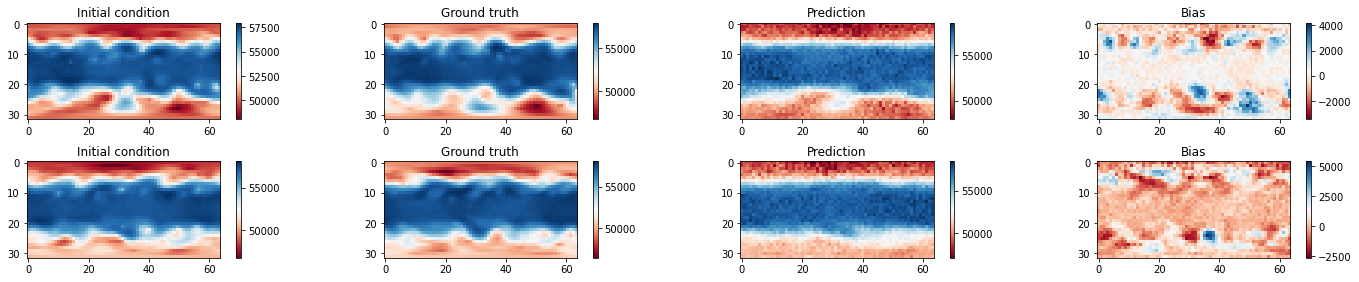

In [ ]:
visualize(resnet_model_module, data_module)

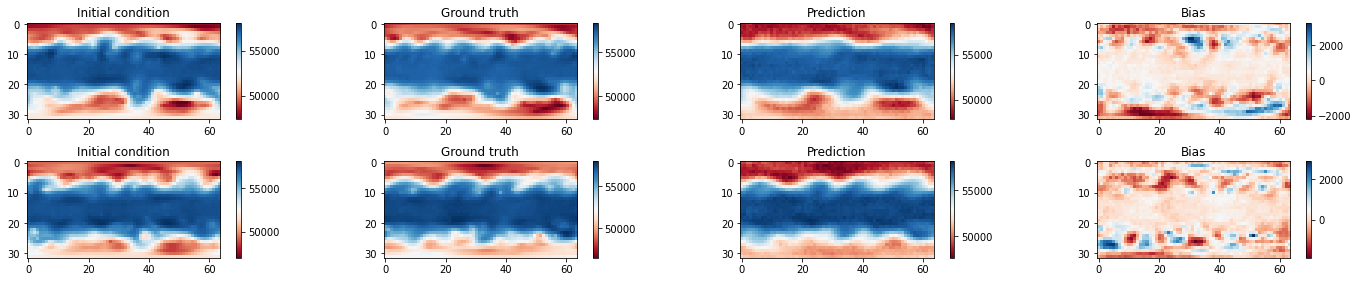

In [ ]:
visualize(unet_model_module, data_module)

In [ ]:
# from climate_tutorial.utils import visualize

import os
import random
import numpy as np
from datetime import datetime
from plotly.express import imshow
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# more use cases for visualize, make a more intuitive api
# which split of the data? train/val/test? currently test with a random data point
# timestamp that we are visualizing?
# only timestamp works -- can infer the split, we don't have the timestamp info for now -> include it in the dataloader
# number: 5 data points

# add lat long information 
# plotly to zoom in

samples = ["2017-01-01:12", "2017-02-01:18"]
def visualize(model_module, data_module, split = "test", samples = 2):
    # dataset.setup()
    dataset = eval(f"data_module.{split}_dataset")

    if(type(samples) == int):
        idxs = random.sample(range(0, len(dataset)), samples)
    elif(type(samples) == list):
        samples = [np.datetime64(datetime.strptime(dt, "%Y-%m-%d:%H")) for dt in samples]
        idxs = [dataset.time.index(dt) for dt in samples if dt in dataset.time]
    else:
        raise Exception("Invalid type for samples; Allowed int or list[datetime.datetime or np.datetime64]")

    # print(dataset.time[idxs[0]])
    # row_titles = [datetime.strftime(None, "%Y-%m-%d:%H") for idx in idxs]

    if(data_module.hparams.task == "forecasting"):
        col_titles = ["Initial condition", "Ground truth", "Prediction", "Bias"]
    elif(data_module.hparams.task == "downscaling"):
        col_titles = ["Low resolution data", "High resolution data", "Downscaled", "Bias"]
    else:
        raise NotImplementedError

    fig = make_subplots(len(idxs), 4, subplot_titles = col_titles * len(idxs))
    for i, idx in enumerate(idxs):
        x, y, _, _ = dataset[idx] # 1, 1, 32, 64
        pred = model_module.forward(x.unsqueeze(0)) # 1, 1, 32, 64

        inv_normalize = model_module.denormalization
        init_condition, gt = inv_normalize(x), inv_normalize(y)
        pred = inv_normalize(pred)
        bias = pred - gt

        for j, tensor in enumerate([init_condition, gt, pred, bias]):
            fig.add_trace(imshow(tensor.detach().squeeze().cpu().numpy(), color_continuous_scale = "rdbu", x = dataset.inp_lon if i == 0 else dataset.out_lon, y = dataset.inp_lat if i == 0 else dataset.out_lat).data[0], row = i + 1, col = j + 1)
            # fig.colorbar(im, ax=ax)

    # fig.tight_layout()
    fig.show()

In [ ]:
visualize(resnet_model_module, data_module)

In [ ]:
visualize(unet_model_module, data_module)

# Temporal Forecasting - T850

## Data Preprocessing


The data is stored in the [NetCDF](https://en.wikipedia.org/wiki/NetCDF) files with _.nc_ extension. One of the distinct features of this format is the **named** specification to the coordinates and the data variables. 

As shown below, we first merge all the yearly NetCDF files, and display the structure of the format. xarray library is used to read the NetCDF files. It allows the users to manipulate data based on more informative labels instead of integer location. 



In [ ]:
from climate_tutorial.utils.data import load_dataset, view

dataset = load_dataset("/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/temperature_850")
view(dataset)

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    level    int32 850
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-21 05:02:47 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

## Data Conversion
We further convert the *NetCDF* files to *PyTorch* Dataloaders.

**Pros**: We can use the dataloaders for training and evaluating neural networks.\
**Cons**: We loose useful meta information (such as 'time', 'location') during conversion as dataloaders only allow for integer location based treatment. 

We store the useful information about the data ('lat', 'long') of the regions as _data members_ of our dataloaders. 



In [ ]:
from climate_tutorial.utils.datetime import Year, Days, Hours
from climate_tutorial.data import DataModule

data_module = DataModule(
    dataset = "ERA5",
    task = "forecasting",
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/",
    in_vars = ["temperature_850"],
    out_vars = ["temperature_850"],
    train_start_year = Year(1979),
    val_start_year = Year(2015),
    test_start_year = Year(2017),
    end_year = Year(2018),
    pred_range = Days(3),
    subsample = Hours(6),
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


  0%|          | 0/36 [00:00<?, ?it/s]

Creating val dataset


  0%|          | 0/2 [00:00<?, ?it/s]

Creating test dataset


  0%|          | 0/2 [00:00<?, ?it/s]

## Model initialization 

In [ ]:
from climate_tutorial.models import load_model

# model_kwargs = {
#     "img_size": [32, 64],
#     "patch_size": 2,
#     "drop_path": 0.1,
#     "drop_rate": 0.1,
#     "learn_pos_emb": True,
#     "in_vars": data_module.hparams.in_vars,
#     "out_vars": data_module.hparams.out_vars,
#     "embed_dim": 128,
#     "depth": 8,
#     "decoder_depth": 0,
#     "num_heads": 4,
#     "mlp_ratio": 4,
# }

model_kwargs = {
    "in_channels": len(data_module.hparams.in_vars),
    "out_channels": len(data_module.hparams.out_vars),
    "n_blocks": 4
}

optim_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

# model_module = load_model(name = "vit", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
resnet_model_module = load_model(name = "resnet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
unet_model_module = load_model(name = "unet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [ ]:
# add_description
from climate_tutorial.models import set_climatology
set_climatology(resnet_model_module, data_module)
set_climatology(unet_model_module, data_module)

## Training

In [ ]:
from climate_tutorial.training import Trainer, WandbLogger

resnet_trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
    # logger = WandbLogger(project = "climate_tutorial", name = "forecast-vit")
)

unet_trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
    # logger = WandbLogger(project = "climate_tutorial", name = "forecast-vit")
)

In [ ]:
resnet_trainer.fit(resnet_model_module, data_module)

┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.2 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │  6.4 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │  6.4 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.2 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.norm                   │ BatchNorm2d       │    256 │
│ 55 │ net.final                  │ PeriodicConv2D    │  6.3 K │
│ 56 │ net.final.padding          │ PeriodicPadding2D │      0 │
│ 57 │ net.final.conv             │ Conv2d            │  6.3 K │
│ 58 │ denormalization            │

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 2

Output()

In [ ]:
unet_trainer.fit(unet_model_module, data_module)

Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434/434 0:09:07 • 0:00:00 1.32it/s loss: 0.0391                      
                                                                                 train/temperature_850: 0.039      
                                                                                 train/loss: 0.039                 

## Evaluation 


Once our prediction model is trained, we want to be able to evaluate it against the ground truth labels for data samples in the test set. 

In addition to the Latitude weighted RMSE (Eq. 1), we shall look at the Anomaly Correlation Coefficient (ACC) which is defined as:

<br>
$ACC = \frac{\sum_{i,j,k}L(j)f'_{i,j,k}t'_{i,j,k}}{\sqrt{\sum_{i,j,k}L(j)f'^{2}_{i,j,k}L(j)t'^{2}_{i,j,k}}} \tag{3}$
<br>

where $'$ denotes the difference to the climatology. We define climatology as:

<br>
$climatology_{j,k} = \frac{1}{N_{time}}\sum{t_{j,k}}\tag{4}$
<br>

In [ ]:
resnet_trainer.test(resnet_model_module, data_module)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23/23 0:00:02 • 0:00:00 8.65it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric            ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test/acc_temperature_850_day_3   │        0.7279096320887262         │
│ test/w_rmse_temperature_850_day_3 │         3.384580282144143         │
└───────────────────────────────────┴───────────────────────────────────┘

In [ ]:
unet_trainer.test(unet_model_module, data_module)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23/23 0:00:08 • 0:00:00 2.66it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric            ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test/acc_temperature_850_day_3   │        0.7963299964054796         │
│ test/w_rmse_temperature_850_day_3 │         3.000032604084627         │
└───────────────────────────────────┴───────────────────────────────────┘

## Visualization 

We visualize the **bias**, given by the difference in the predicted and the ground truth values, to better analyze our learned model.

In [1]:
# from climate_tutorial.utils import visualize

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# more use cases for visualize, make a more intuitive api
# which split of the data? train/val/test? currently test with a random data point
# timestamp that we are visualizing?
# only timestamp works -- can infer the split, we don't have the timestamp info for now -> include it in the dataloader
# number: 5 data points

# add lat long information 
# plotly to zoom in

samples = []
def visualize(model_module, data_module, split = "test", samples = 2, save_dir = None):
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok = True)

    # dataset.setup()
    dataset = eval(f"data_module.{split}_dataset")

    if(type(samples) == int):
        idxs = random.sample(range(0, len(dataset)), samples)
    elif(type(samples) == list):
        idxs = [np.searchsorted(dataset.time, np.datetime64(datetime.strptime(dt, "%Y-%m-%d:%H"))) for dt in samples]
    else:
        raise Exception("Invalid type for samples; Allowed int or list[datetime.datetime or np.datetime64]")

    fig, axes = plt.subplots(len(idxs), 4, figsize=(20, 2 * len(idxs)), squeeze = False)

    for index, idx in enumerate(idxs):
        x, y, _, _ = dataset[idx] # 1, 1, 32, 64
        pred = model_module.forward(x.unsqueeze(0)) # 1, 1, 32, 64

        inv_normalize = model_module.denormalization
        init_condition, gt = inv_normalize(x), inv_normalize(y)
        pred = inv_normalize(pred)
        bias = pred - gt

        for i, tensor in enumerate([init_condition, gt, pred, bias]):
            ax = axes[index][i]
            im = ax.imshow(tensor.detach().squeeze().cpu().numpy())
            im.set_cmap(cmap=plt.cm.RdBu)
            fig.colorbar(im, ax=ax)

        if(data_module.hparams.task == "forecasting"):
            axes[index][0].set_title("Initial condition")
            axes[index][1].set_title("Ground truth")
            axes[index][2].set_title("Prediction")
            axes[index][3].set_title("Bias")
        elif(data_module.hparams.task == "downscaling"):
            axes[index][0].set_title("Low resolution data")
            axes[index][1].set_title("High resolution data")
            axes[index][2].set_title("Downscaled")
            axes[index][3].set_title("Bias")
        else:
            raise NotImplementedError

    fig.tight_layout()
    
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, 'visualize.png'))
    else:
        plt.show()

In [2]:
visualize(resnet_model_module, data_module)

NameError: ignored

In [ ]:
visualize(unet_model_module, data_module)

In [ ]:
# from climate_tutorial.utils import visualize

import os
import random
import numpy as np
from datetime import datetime
from plotly.express import imshow
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# more use cases for visualize, make a more intuitive api
# which split of the data? train/val/test? currently test with a random data point
# timestamp that we are visualizing?
# only timestamp works -- can infer the split, we don't have the timestamp info for now -> include it in the dataloader
# number: 5 data points

# add lat long information 
# plotly to zoom in

samples = ["2017-01-01:12", "2017-02-01:18"]
def visualize(model_module, data_module, split = "test", samples = 2):
    # dataset.setup()
    dataset = eval(f"data_module.{split}_dataset")

    if(type(samples) == int):
        idxs = random.sample(range(0, len(dataset)), samples)
    elif(type(samples) == list):
        samples = [np.datetime64(datetime.strptime(dt, "%Y-%m-%d:%H")) for dt in samples]
        idxs = [dataset.time.index(dt) for dt in samples if dt in dataset.time]
    else:
        raise Exception("Invalid type for samples; Allowed int or list[datetime.datetime or np.datetime64]")

    # print(dataset.time[idxs[0]])
    # row_titles = [datetime.strftime(None, "%Y-%m-%d:%H") for idx in idxs]

    if(data_module.hparams.task == "forecasting"):
        col_titles = ["Initial condition", "Ground truth", "Prediction", "Bias"]
    elif(data_module.hparams.task == "downscaling"):
        col_titles = ["Low resolution data", "High resolution data", "Downscaled", "Bias"]
    else:
        raise NotImplementedError

    fig = make_subplots(len(idxs), 4, subplot_titles = col_titles * len(idxs))
    for i, idx in enumerate(idxs):
        x, y, _, _ = dataset[idx] # 1, 1, 32, 64
        pred = model_module.forward(x.unsqueeze(0)) # 1, 1, 32, 64

        inv_normalize = model_module.denormalization
        init_condition, gt = inv_normalize(x), inv_normalize(y)
        pred = inv_normalize(pred)
        bias = pred - gt

        for j, tensor in enumerate([init_condition, gt, pred, bias]):
            fig.add_trace(imshow(tensor.detach().squeeze().cpu().numpy(), color_continuous_scale = "rdbu", x = dataset.inp_lon if i == 0 else dataset.out_lon, y = dataset.inp_lat if i == 0 else dataset.out_lat).data[0], row = i + 1, col = j + 1)
            # fig.colorbar(im, ax=ax)

    # fig.tight_layout()
    fig.show()

In [ ]:
visualize(resnet_model_module, data_module)

In [ ]:
visualize(unet_model_module, data_module)

# Temporal Forecasting - Z500 & T850

## Data Preprocessing


The data is stored in the [NetCDF](https://en.wikipedia.org/wiki/NetCDF) files with _.nc_ extension. One of the distinct features of this format is the **named** specification to the coordinates and the data variables. 

As shown below, we first merge all the yearly NetCDF files, and display the structure of the format. xarray library is used to read the NetCDF files. It allows the users to manipulate data based on more informative labels instead of integer location. 



In [7]:
from climate_tutorial.utils.data import load_dataset, view
import xarray as xr

z_dataset = load_dataset("/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/geopotential_500")
t_dataset = load_dataset("/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/temperature_850")
dataset = xr.merge([z_dataset.drop("level"), t_dataset.drop("level")])
view(dataset)

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [8]:
view(z_dataset)

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [9]:
view(t_dataset)

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    level    int32 850
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-21 05:02:47 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

## Data Conversion
We further convert the *NetCDF* files to *PyTorch* Dataloaders.

**Pros**: We can use the dataloaders for training and evaluating neural networks.\
**Cons**: We loose useful meta information (such as 'time', 'location') during conversion as dataloaders only allow for integer location based treatment. 

We store the useful information about the data ('lat', 'long') of the regions as _data members_ of our dataloaders. 



In [10]:
from climate_tutorial.utils.datetime import Year, Days, Hours
from climate_tutorial.data import DataModule

data_module = DataModule(
    dataset = "ERA5",
    task = "forecasting",
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/",
    in_vars = ["geopotential_500", "temperature_850"],
    out_vars = ["geopotential_500", "temperature_850"],
    train_start_year = Year(1979),
    val_start_year = Year(2015),
    test_start_year = Year(2017),
    end_year = Year(2018),
    pred_range = Days(3),
    subsample = Hours(6),
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


  0%|          | 0/36 [00:00<?, ?it/s]

Creating val dataset


  0%|          | 0/2 [00:00<?, ?it/s]

Creating test dataset


  0%|          | 0/2 [00:00<?, ?it/s]

## Model initialization 

In [11]:
from climate_tutorial.models import load_model

# model_kwargs = {
#     "img_size": [32, 64],
#     "patch_size": 2,
#     "drop_path": 0.1,
#     "drop_rate": 0.1,
#     "learn_pos_emb": True,
#     "in_vars": data_module.hparams.in_vars,
#     "out_vars": data_module.hparams.out_vars,
#     "embed_dim": 128,
#     "depth": 8,
#     "decoder_depth": 0,
#     "num_heads": 4,
#     "mlp_ratio": 4,
# }

model_kwargs = {
    "in_channels": len(data_module.hparams.in_vars),
    "out_channels": len(data_module.hparams.out_vars),
    "n_blocks": 4
}

optim_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

# model_module = load_model(name = "vit", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
resnet_model_module = load_model(name = "resnet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
unet_model_module = load_model(name = "unet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [12]:
# add_description
from climate_tutorial.models import set_climatology
set_climatology(resnet_model_module, data_module)
set_climatology(unet_model_module, data_module)

## Training

In [13]:
from climate_tutorial.training import Trainer, WandbLogger

resnet_trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
    # logger = WandbLogger(project = "climate_tutorial", name = "forecast-vit")
)

unet_trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
    # logger = WandbLogger(project = "climate_tutorial", name = "forecast-vit")
)

In [14]:
resnet_trainer.fit(resnet_model_module, data_module)

┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.2 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │ 12.7 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │ 12.7 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.2 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.norm                   │ BatchNorm2d       │    256 │
│ 55 │ net.final                  │ PeriodicConv2D    │ 12.5 K │
│ 56 │ net.final.padding          │ PeriodicPadding2D │      0 │
│ 57 │ net.final.conv             │ Conv2d            │ 12.5 K │
│ 58 │ denormalization            │

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 2

Output()

In [15]:
unet_trainer.fit(unet_model_module, data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     ┃ Name                          ┃ Type              ┃ Params ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0   │ net                           │ Unet              │  250 M │
│ 1   │ net.activation                │ LeakyReLU         │      0 │
│ 2   │ net.image_proj                │ PeriodicConv2D    │  6.3 K │
│ 3   │ net.image_proj.padding        │ PeriodicPadding2D │      0 │
│ 4   │ net.image_proj.conv           │ Conv2d            │  6.3 K │
│ 5   │ net.down                      │ ModuleList        │ 75.4 M │
│ 6   │ net.down.0                    │ DownBlock         │ 74.1 K │
│ 7   │ net.down.0.res                │ ResidualBlock     │ 74.1 K │
│ 8   │ net.down.0.res.activation     │ LeakyReLU         │      0 │
│ 9   │ net.down.0.res.conv1          │ PeriodicConv2D    │ 36.9 K │
│ 10  │ net.down.0.res.conv1.padding  │ PeriodicPadding2D │      0 │
│ 11  │ net.down.0.res.conv1.conv     │ Conv2d            │ 36.9 K │
│ 12  │ net.down.0.res.conv2          │ PeriodicConv2D    │ 36.9 K │
│ 13  │ net.down.0.res.conv2.padding  │ PeriodicPadding2D │      0 │
│ 14  │ net.down.0.res.conv2.conv     │ Conv2d            │ 36.9 K │
│ 15  │ net.down.0.res.shortcut       │ Identity          │      0 │
│ 16  │ net.down.0.res.norm1          │ BatchNorm2d       │    128 │
│ 17  │ net.down.0.res.norm2          │ BatchNorm2d       │    128 │
│ 18  │ net.down.0.res.drop           │ Dropout           │      0 │
│ 19  │ net.down.0.attn               │ Identity          │      0 │
│ 20  │ net.down.1                    │ DownBlock         │ 74.1 K │
│ 21  │ net.down.1.res                │ ResidualBlock     │ 74.1 K │
│ 22  │ net.down.1.res.activation     │ LeakyReLU         │      0 │
│ 23  │ net.down.1.res.conv1          │ PeriodicConv2D    │ 36.9 K │
│ 24  │ net.down.1.res.conv1.padding  │ PeriodicPadding2D │      0 │
│ 25  │ net.down.1.res.conv1.conv     │ Conv2d            │ 36.9 K │
│ 26  │ net.down.1.res.conv2          │ PeriodicConv2D    │ 36.9 K │
│ 27  │ net.down.1.res.conv2.padding  │ PeriodicPadding2D │      0 │
│ 28  │ net.down.1.res.conv2.conv     │ Conv2d            │ 36.9 K │
│ 29  │ net.down.1.res.shortcut       │ Identity          │      0 │
│ 30  │ net.down.1.res.norm1          │ BatchNorm2d       │    128 │
│ 31  │ net.down.1.res.norm2          │ BatchNorm2d       │    128 │
│ 32  │ net.down.1.res.drop           │ Dropout           │      0 │
│ 33  │ net.down.1.attn               │ Identity          │      0 │
│ 34  │ net.down.2                    │ DownBlock         │ 74.1 K │
│ 35  │ net.down.2.res                │ ResidualBlock     │ 74.1 K │
│ 36  │ net.down.2.res.activation     │ LeakyReLU         │      0 │
│ 37  │ net.down.2.res.conv1          │ PeriodicConv2D    │ 36.9 K │
│ 38  │ net.down.2.res.conv1.padding  │ PeriodicPadding2D │      0 │
│ 39  │ net.down.2.res.conv1.conv     │ Conv2d            │ 36.9 K │
│ 40  │ net.down.2.res.conv2          │ PeriodicConv2D    │ 36.9 K │
│ 41  │ net.down.2.res.conv2.padding  │ PeriodicPadding2D │      0 │
│ 42  │ net.down.2.res.conv2.conv     │ Conv2d            │ 36.9 K │
│ 43  │ net.down.2.res.shortcut       │ Identity          │      0 │
│ 44  │ net.down.2.res.norm1          │ BatchNorm2d       │    128 │
│ 45  │ net.down.2.res.norm2          │ BatchNorm2d       │    128 │
│ 46  │ net.down.2.res.drop           │ Dropout           │      0 │
│ 47  │ net.down.2.attn               │ Identity          │      0 │
│ 48  │ net.down.3                    │ DownBlock         │ 74.1 K │
│ 49  │ net.down.3.res                │ ResidualBlock     │ 74.1 K │
│ 50  │ net.down.3.res.activation     │ LeakyReLU         │      0 │
│ 51  │ net.down.3.res.conv1          │ PeriodicConv2D    │ 36.9 K │
│ 52  │ net.down.3.res.conv1.padding  │ PeriodicPadding2D │      0 │
│ 53  │ net.down.3.res.conv1.conv     │ Conv2d            │ 36.9 K │
│ 54  │ net.down.3.res.conv2          │ PeriodicConv2D    │ 36.9 K 

Trainable params: 250 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 250 M                                                                                                
Total estimated model params size (MB): 501

Output()

## Evaluation 


Once our prediction model is trained, we want to be able to evaluate it against the ground truth labels for data samples in the test set. 

In addition to the Latitude weighted RMSE (Eq. 1), we shall look at the Anomaly Correlation Coefficient (ACC) which is defined as:

<br>
$ACC = \frac{\sum_{i,j,k}L(j)f'_{i,j,k}t'_{i,j,k}}{\sqrt{\sum_{i,j,k}L(j)f'^{2}_{i,j,k}L(j)t'^{2}_{i,j,k}}} \tag{3}$
<br>

where $'$ denotes the difference to the climatology. We define climatology as:

<br>
$climatology_{j,k} = \frac{1}{N_{time}}\sum{t_{j,k}}\tag{4}$
<br>

In [16]:
resnet_trainer.test(resnet_model_module, data_module)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric             ┃            DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test/acc_geopotential_500_day_3   │         0.682861502690745          │
│   test/acc_temperature_850_day_3   │         0.7351145881814655         │
│ test/w_rmse_geopotential_500_day_3 │          731.310376308985          │
│ test/w_rmse_temperature_850_day_3  │         3.3532816903972127         │
└────────────────────────────────────┴────────────────────────────────────┘

In [17]:
unet_trainer.test(unet_model_module, data_module)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric             ┃            DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test/acc_geopotential_500_day_3   │         0.8397192879797946         │
│   test/acc_temperature_850_day_3   │         0.8298908712295446         │
│ test/w_rmse_geopotential_500_day_3 │          545.953781005853          │
│ test/w_rmse_temperature_850_day_3  │         2.7775451071698916         │
└────────────────────────────────────┴────────────────────────────────────┘